### Misc Notes: 
- All images for color_labels, images, labels 1280x720
- Currently trying 128 resize with padding to 128x128
    - Initially had padding as white but then realized that could conflict with labels so changed all to skyblue

### Todo:
- Images not lining up with masks?
    - trn/trn_mask are in order so model is likely to be training in correct order
- Possibly try resnet50

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
# from fastai.models.resnet import vgg_resnet50

from pathlib import Path
import json

/home/ray/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
torch.cuda.set_device(0)

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
PATH = Path('/home/ray/BDD/bdd100k/seg2_128')
os.listdir(PATH)

['color_labels',
 'tmp',
 'images',
 'train-128',
 'labels',
 'models',
 'train_masks-128']

In [7]:
sz = 128
bs = 64
nw = 16

aug_tfms = []

In [8]:
TRAIN = Path('{}/images/train'.format(PATH))
trn = sorted(glob(os.path.join(TRAIN, "*.jpg")))

TRAIN_MASKS = Path('{}/color_labels/train'.format(PATH))
trn_msk = sorted(glob(os.path.join(TRAIN_MASKS, "*.png")))

VALID = Path('{}/images/val'.format(PATH))
vld = sorted(glob(os.path.join(VALID, "*.jpg")))

VALID_MASKS = Path('{}/color_labels/val'.format(PATH))
vld_msk = sorted(glob(os.path.join(VALID_MASKS, "*.png")))

In [9]:
# TEST PATHS
# os.listdir(PATH)
# os.listdir(TRAIN)
# os.listdir(TRAIN_MASKS)
# os.listdir(VALID)
# os.listdir(VALID_MASKS)

# Data analyzing. Looking at small sample of images, resolution, planning ways to prep data

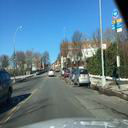

In [10]:
TEST_SINGLE_ID = '47406c52-6f9c5dbf'
Image.open(PATH/TRAIN/f'{TEST_SINGLE_ID}.jpg')

In [11]:
# TRAIN_IDS = [str(trn).split('/')[-1] for trn in list((PATH/TRAIN)).iterdir()]
# TRAIN_MASK_IDS = [str(trn_msk).split('/')[-1] for trn_msk in list((PATH/TRAIN_MASKS)).iterdir()]

TRAIN_IDS = [str(TRAIN).split('/')[-1] for TRAIN in list((PATH/TRAIN).iterdir())]
TRAIN_MASK_IDS = [str(TRAIN_MASKS).split('/')[-1] for TRAIN_MASKS in list((PATH/TRAIN_MASKS).iterdir())]

In [12]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [13]:
# ims = [open_image(PATH/TRAIN/f'{SINGLE_ID}') for SINGLE_ID in TRAIN_IDS[:16]]
# im_masks = [open_image(PATH/TRAIN_MASKS/f'{SINGLE_ID}') for SINGLE_ID in TRAIN_MASK_IDS[:16]]

ims = [open_image(PATH/TRAIN/f'{SINGLE_ID}') for SINGLE_ID in sorted(TRAIN_IDS[:16])]
im_masks = [open_image(PATH/TRAIN_MASKS/f'{SINGLE_ID}') for SINGLE_ID in sorted(TRAIN_MASK_IDS[:16])]

# ims = sorted(glob.glob(os.path.join(TRAIN, "*.jpg")))
# im_masks = sorted(glob.glob(os.path.join(TRAIN_MASKS, "*.png")))

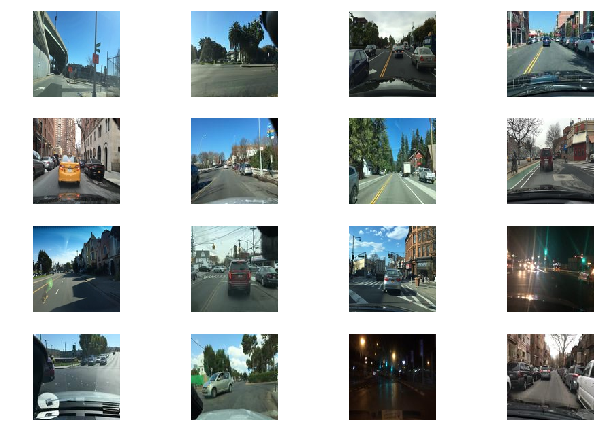

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
plt.tight_layout(pad=0.1)

# Note to self: seems to be a lot of streets from small sample of 16.
# TODO: Figure out how to handle edge cases of night segmentation
# ???: Will reflection on windshield cause errors? Should sky be cropped as well? Reference 21:9 dash cams
# TOLEARN: Better to squash images to 1:1 aspect ratio as beginning will be trained with resnet? Or make image with padding?
# ie 1280x1280 with rest of height being padding

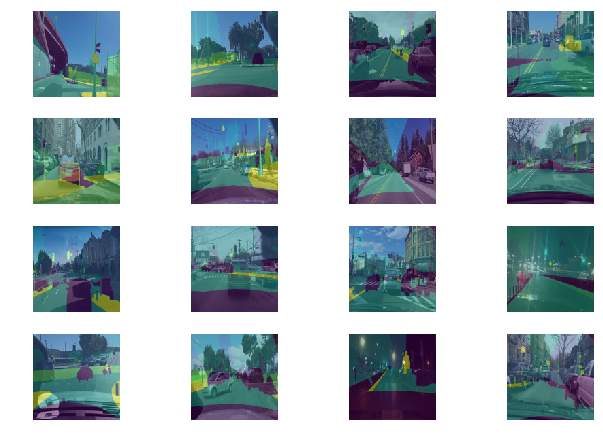

In [15]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

# print("ims:",ims)
# print("im_masks:",im_masks)

In [16]:
from PIL import Image
import os.path

filename = os.path.join(PATH/TRAIN)
# img_to_plot = Image.open(filename)
for SINGLE_ID in sorted(TRAIN_IDS[:16]):
    img_to_plot = Image.open(PATH/TRAIN/f'{SINGLE_ID}')
    width, height = img_to_plot.size
    print("SINGLE_ID:", SINGLE_ID, "Dimensions:", img_to_plot.size)
    
for SINGLE_ID in sorted(TRAIN_MASK_IDS[:16]):
    img_to_plot = Image.open(PATH/TRAIN_MASKS/f'{SINGLE_ID}')
    width, height = img_to_plot.size
    print("SINGLE_MASK_ID:", SINGLE_ID, "Dimensions:", img_to_plot.size)

SINGLE_ID: 0378d8dc-62d8851d.jpg Dimensions: (128, 128)
SINGLE_ID: 08cc3547-a9930000.jpg Dimensions: (128, 128)
SINGLE_ID: 0c7aa2a6-9c0f3111.jpg Dimensions: (128, 128)
SINGLE_ID: 3f291ac3-d2abcdbd.jpg Dimensions: (128, 128)
SINGLE_ID: 444450f8-eb43d2b7.jpg Dimensions: (128, 128)
SINGLE_ID: 47406c52-6f9c5dbf.jpg Dimensions: (128, 128)
SINGLE_ID: 49c6e2f0-00000000.jpg Dimensions: (128, 128)
SINGLE_ID: 4c091ad8-6ea5f0d1.jpg Dimensions: (128, 128)
SINGLE_ID: 4fc15031-9165c3f3.jpg Dimensions: (128, 128)
SINGLE_ID: 614fd0a8-9891cb51.jpg Dimensions: (128, 128)
SINGLE_ID: 6db48fb9-5aeece40.jpg Dimensions: (128, 128)
SINGLE_ID: 700c3115-5b5b7652.jpg Dimensions: (128, 128)
SINGLE_ID: 96fc479b-ff3929ea.jpg Dimensions: (128, 128)
SINGLE_ID: 9e771b2e-2d041638.jpg Dimensions: (128, 128)
SINGLE_ID: b674bc13-3e309d54.jpg Dimensions: (128, 128)
SINGLE_ID: bd46953e-1bb2f914.jpg Dimensions: (128, 128)
SINGLE_MASK_ID: 0378d8dc-62d8851d_train_color.png Dimensions: (128, 128)
SINGLE_MASK_ID: 157a9cee-5ce9ec

In [17]:
# NOTE: Disabled for speed when restarting kernel. All 10k+ images in original training set are set to dimensions stated at top


# import matplotlib.pyplot as plt

# for SINGLE_ID in TRAIN_IDS:
#     img_to_plot = Image.open(PATH/TRAIN/f'{SINGLE_ID}')
#     width, height = img_to_plot.size
#     plt.plot([width], [height], 'ro')

# plt.xlabel('Width')
# plt.ylabel('Height')
# plt.show()

# Data Prep

In [18]:
img_x = Image.open(trn[0])
print("np.asarray(img_x).shape:", np.asarray(img_x).shape)

img_y = Image.open(trn_msk[0])
print("np.asarray(img_y).shape:", np.asarray(img_y).shape)

np.asarray(img_x).shape: (128, 128, 3)
np.asarray(img_y).shape: (128, 128, 4)


In [19]:
print('Len train set: {} len train mask set: {}'.format(len(trn), len(trn_msk)))
print('Len valid set: {} Len valid mask set: {}'.format(len(vld), len(vld_msk)))

Len train set: 7000 len train mask set: 7000
Len valid set: 1000 Len valid mask set: 1000


In [20]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [21]:
# TRAIN_DIRS = list(TRAIN.iterdir())
# TEST_DIRS = list(TEST.iterdir())

In [22]:
# TRAIN_X = [str(x_name/'images'/x_name.name) + '.png' for x_name in TRAIN_DIRS]
# TRAIN_Y = [str(x_name/'multiclass_mask.png') for x_name in TRAIN_DIRS]
# TEST_X = [str(x_name/'images'/x_name.name) + '.png' for x_name in TEST_DIRS]
# TEST_Y = np.random.choice(TRAIN_Y, len(TEST_X))

In [23]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, aug_tfms=[])
datasets = ImageData.get_ds(MatchedFilesDataset, (trn,trn_msk), (vld,vld_msk), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [24]:
import pprint

pp = pprint.PrettyPrinter(indent=4)

pp.pprint(trn[:10])

[   '/home/ray/BDD/bdd100k/seg2_128/images/train/0004a4c0-d4dff0ad.jpg',
    '/home/ray/BDD/bdd100k/seg2_128/images/train/00054602-3bf57337.jpg',
    '/home/ray/BDD/bdd100k/seg2_128/images/train/00067cfb-e535423e.jpg',
    '/home/ray/BDD/bdd100k/seg2_128/images/train/00091078-59817bb0.jpg',
    '/home/ray/BDD/bdd100k/seg2_128/images/train/0010bf16-a457685b.jpg',
    '/home/ray/BDD/bdd100k/seg2_128/images/train/001b428f-059bac33.jpg',
    '/home/ray/BDD/bdd100k/seg2_128/images/train/001c2a14-c7138401.jpg',
    '/home/ray/BDD/bdd100k/seg2_128/images/train/0024b742-acbefa1a.jpg',
    '/home/ray/BDD/bdd100k/seg2_128/images/train/0027eed2-09c90000.jpg',
    '/home/ray/BDD/bdd100k/seg2_128/images/train/0027eed2-09c90001.jpg']


In [25]:
pp.pprint(trn_msk[:10])

[   '/home/ray/BDD/bdd100k/seg2_128/color_labels/train/0004a4c0-d4dff0ad_train_color.png',
    '/home/ray/BDD/bdd100k/seg2_128/color_labels/train/00054602-3bf57337_train_color.png',
    '/home/ray/BDD/bdd100k/seg2_128/color_labels/train/00067cfb-e535423e_train_color.png',
    '/home/ray/BDD/bdd100k/seg2_128/color_labels/train/00091078-59817bb0_train_color.png',
    '/home/ray/BDD/bdd100k/seg2_128/color_labels/train/0010bf16-a457685b_train_color.png',
    '/home/ray/BDD/bdd100k/seg2_128/color_labels/train/001b428f-059bac33_train_color.png',
    '/home/ray/BDD/bdd100k/seg2_128/color_labels/train/001c2a14-c7138401_train_color.png',
    '/home/ray/BDD/bdd100k/seg2_128/color_labels/train/0024b742-acbefa1a_train_color.png',
    '/home/ray/BDD/bdd100k/seg2_128/color_labels/train/0027eed2-09c90000_train_color.png',
    '/home/ray/BDD/bdd100k/seg2_128/color_labels/train/0027eed2-09c90001_train_color.png']


In [26]:
print(datasets)

[<__main__.MatchedFilesDataset object at 0x7f68e2b251d0>, <__main__.MatchedFilesDataset object at 0x7f68e46cda90>, <__main__.MatchedFilesDataset object at 0x7f68e46cd3c8>, <__main__.MatchedFilesDataset object at 0x7f68e46cdbe0>, None, None]


In [27]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)
y = to_np(y)

y[2].shape

(128, 128, 3)

# Model Training

In [28]:
f = resnet34
cut,lr_cut = model_meta[f]

In [29]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [30]:
def mask_loss(pred,targ):
    return F.binary_cross_entropy_with_logits(pred[:,0],targ[...,0])

def mask_acc(pred,targ): return accuracy_multi(pred[:,0], targ[...,0], 0.)

In [31]:
def dice(pred, targs):
    m1 = (pred[:,0]>0).float()
    m2 = targs[...,0]
    return 2. * (m1*m2).sum() / (m1+m2).sum()

# def dice(pred, targs):
#     pred = (pred>0).float()
#     return 2. * (pred*targs).sum() / (pred+targs).sum()

In [32]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [33]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.up1 = StdUpsample(512,256)
        self.up2 = StdUpsample(256,256)
        self.up3 = StdUpsample(256,256)
        self.up4 = StdUpsample(256,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)        
        x = self.up4(x)
        x = self.up5(x)
        return x

In [34]:
m_base = get_base()

In [35]:
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [36]:
m = to_gpu(Upsample34(m_base))
models = UpsampleModel(m)

In [37]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

# learn = ConvLearner(md, models)
# learn.opt_fn=optim.Adam
# learn.crit=nn.BCEWithLogitsLoss()
# learn.metrics=[accuracy_thresh(0.5),dice]

In [38]:
learn.freeze_to(1)

 85%|████████▍ | 93/110 [00:17<00:03,  5.43it/s, loss=2.35] 

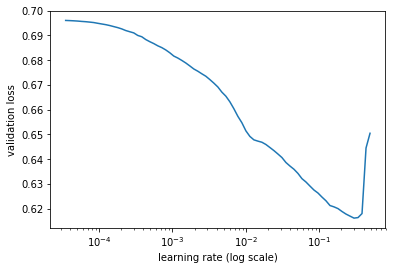

In [39]:
learn.lr_find()
learn.sched.plot()

In [42]:
lr = .01
# lr=.1
# wd=1e-7
# lrs = np.array([lr/100,lr/10,lr])/2

In [43]:
# learn.fit(lr,1, wds=wd, cycle_len=100,use_clr=(20,8))

learn.fit(lr,1,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   mask_acc   dice             
    0      0.54524    0.559258   0.212774   0.30963   
    1      0.537005   0.558246   0.212121   0.305874         
    2      0.531084   0.548142   0.21217    0.319688         
    3      0.525655   0.546921   0.212393   0.291111         


[array([0.54692]), 0.21239288318157196, 0.29111075716914975]

 81%|████████  | 89/110 [00:15<00:03,  5.58it/s, loss=1.02] 

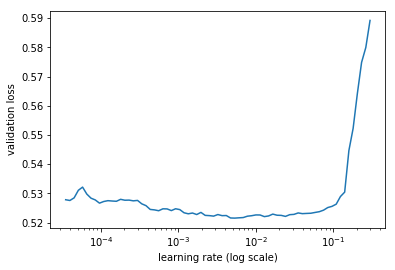

In [44]:
learn.lr_find()
learn.sched.plot()

In [45]:
learn.fit(lr,1,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   mask_acc   dice             
    0      0.525409   0.550385   0.214051   0.160572  
    1      0.520798   0.547527   0.212833   0.279527         
    2      0.514491   0.54785    0.210476   0.319388         
    3      0.50993    0.546928   0.211021   0.313381         


[array([0.54693]), 0.2110209963321686, 0.3133809460710382]

In [46]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


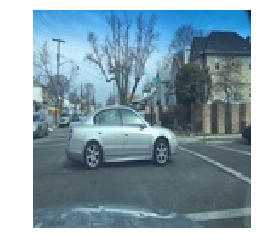

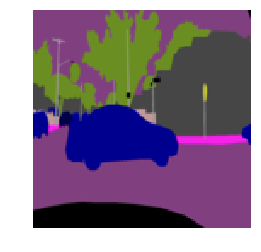

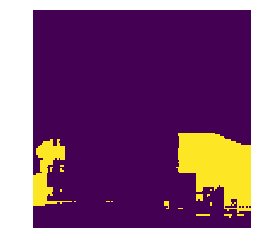

In [47]:
show_img((x[3,:].transpose(0,2).transpose(0,1)+2.5)/5)
show_img(y[3])
show_img(py[3][0]>0);

In [48]:
learn.save('128')

# Trying out a Unet

In [49]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [50]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [51]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x
 
    def close(self):
        for sf in self.sfs: sf.remove()

In [52]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UpsampleModel(m)

In [53]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

In [54]:
learn.freeze_to(1)

 84%|████████▎ | 92/110 [00:16<00:03,  5.68it/s, loss=2.1]  

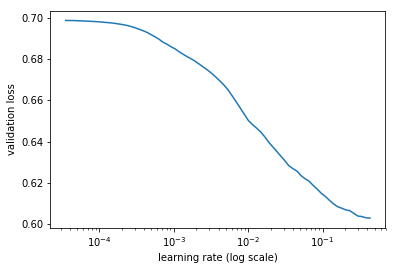

In [55]:
learn.lr_find()
learn.sched.plot()

In [56]:
lr = .1

In [57]:
learn.fit(lr,1,cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   mask_acc   dice             
    0      0.545302   0.58145    0.209805   0.376677  
    1      0.534953   0.550749   0.209789   0.34819          
    2      0.529165   0.546714   0.209231   0.384746         
    3      0.522206   0.555036   0.21353    0.224148         
    4      0.515741   0.54162    0.211968   0.358893         
    5      0.51318    0.542933   0.211731   0.314477         
    6      0.507015   0.540675   0.210004   0.383878         
    7      0.502316   0.539858   0.21164    0.333513         


[array([0.53986]), 0.2116396485567093, 0.33351259130986255]

In [58]:
learn.save('128-tmp')

In [59]:
learn.load('128-tmp')

In [60]:
learn.unfreeze()
learn.bn_freeze(True)
lrs = np.array([lr/100,lr/10,lr])

In [61]:
learn.fit(lrs,1,cycle_len=20,use_clr=(20,10))

epoch      trn_loss   val_loss   mask_acc   dice             
    0      0.513718   0.546237   0.211721   0.268584  
    1      0.52567    0.551495   0.215396   0.13281          
    2      0.519412   0.542324   0.213339   0.207007         
    3      0.513919   0.550652   0.214475   0.118768         
    4      0.508686   0.543475   0.212369   0.2519           
    5      0.501755   0.54337    0.211379   0.336958         
    6      0.499198   0.543528   0.213063   0.185272         
    7      0.497933   0.547295   0.211141   0.331741         
    8      0.495634   0.543643   0.208258   0.408942         
    9      0.495523   0.554655   0.209471   0.361536         
    14     0.486756   0.547949   0.210468   0.363223         
    15     0.483481   0.546425   0.212453   0.209561         
    16     0.48315    0.549094   0.21164    0.287512         
    17     0.482324   0.552371   0.210699   0.36272          
    18     0.482729   0.553582   0.20966    0.398596         
    19     0.48

[array([0.55558]), 0.2104710692167282, 0.3540640724454467]

In [62]:
learn.save('128un-0')

In [63]:
learn.load('128un-0')

In [64]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

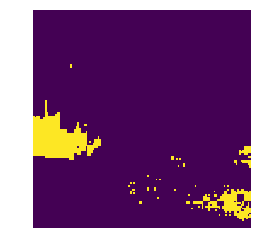

In [65]:
show_img(py[0][0]>0);

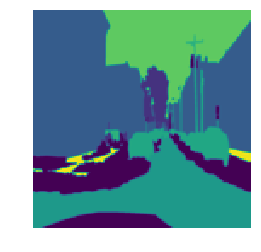

In [66]:
show_img(y[0,...,-1]);

In [67]:
m.close()

# 512 x 512

In [68]:
PATH = Path('/home/ray/BDD/bdd100k/seg2_512')
os.listdir(PATH)
sz = 512
bs = 4

In [69]:
TRAIN = Path('{}/images/train'.format(PATH))
trn = sorted(glob(os.path.join(TRAIN, "*.jpg")))

TRAIN_MASKS = Path('{}/color_labels/train'.format(PATH))
trn_msk = sorted(glob(os.path.join(TRAIN_MASKS, "*.png")))

VALID = Path('{}/images/val'.format(PATH))
vld = sorted(glob(os.path.join(VALID, "*.jpg")))

VALID_MASKS = Path('{}/color_labels/val'.format(PATH))
vld_msk = sorted(glob(os.path.join(VALID_MASKS, "*.png")))

In [70]:
img_x = Image.open(trn[0])
print("np.asarray(img_x).shape:", np.asarray(img_x).shape)

np.asarray(img_x).shape: (512, 512, 3)


In [71]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, aug_tfms=[])
datasets = ImageData.get_ds(MatchedFilesDataset, (trn,trn_msk), (vld,vld_msk), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
denorm = md.trn_ds.denorm

In [72]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UpsampleModel(m)

In [73]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

learn.freeze_to(1)

In [74]:
learn.load('128un-0')

In [75]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   mask_acc   dice               
    0      0.554089   0.547278   0.230197   0.256552  
    1      0.549472   0.593443   0.232948   0.142981           
    2      0.52778    0.531622   0.227464   0.447414           
    3      0.523073   0.528189   0.234159   0.107653           
    4      0.512437   0.523021   0.232218   0.208372           


[array([0.52302]), 0.23221766662597657, 0.2083721140623208]

In [76]:
learn.save('512un-0')

 79%|███████▉  | 1381/1750 [04:11<01:07,  5.48it/s, loss=1.47] 

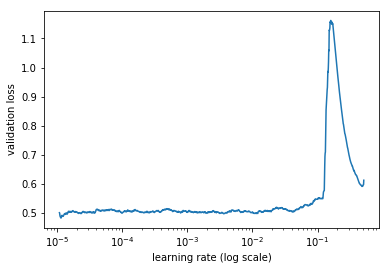

In [77]:
learn.lr_find()
learn.sched.plot()